Homework set 3

In [16]:
#importing libraries
import numpy as np
import quantecon as qe
from scipy.interpolate import CubicSpline,interp1d,InterpolatedUnivariateSpline
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

## Problem 9.3


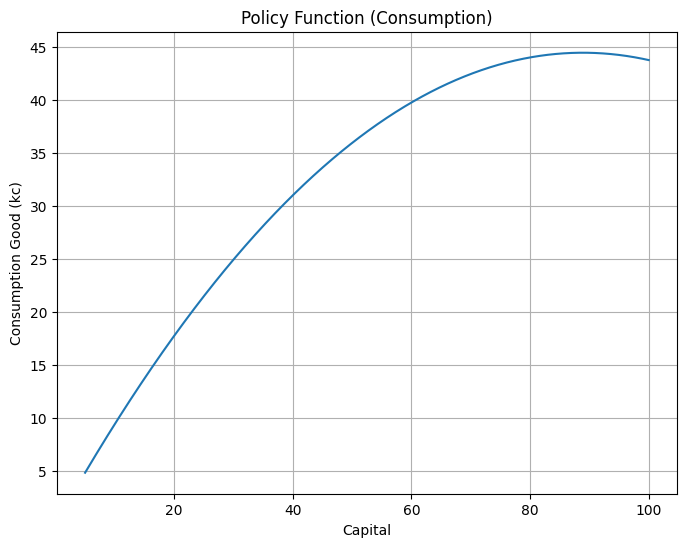

In [31]:
#parameters
gamma, beta, alpha_c, alpha_i, depreciation_rate = 0.5, 0.99, 0.5, 0.5, 0.075
lower_bound, upper_bound, convergence_threshold, iterations, grid_size = 5.0, 100.0, 1e-6, 1000, 1000
verbose = False

capital_grid = np.linspace(lower_bound, upper_bound, grid_size+1)
consumption_grid = capital_grid - (depreciation_rate*capital_grid)**(1/alpha_i)

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(capital_grid, consumption_grid)
plt.title("Policy Function (Consumption)")
plt.xlabel("Capital")
plt.ylabel("Consumption Good (kc)")
plt.grid(True)
plt.show()

Converged after 126 iterations


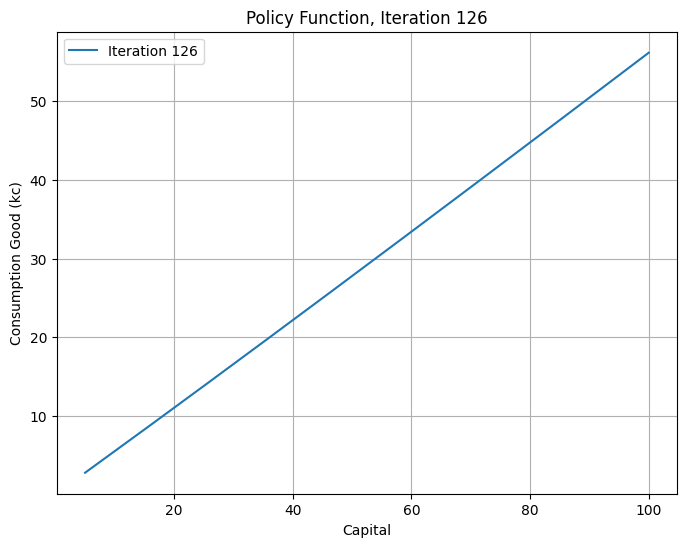

In [32]:
def compute_next_k(consumption_capital, total_capital):
    return (1-depreciation_rate)*total_capital + (total_capital-consumption_capital)**alpha_i


def inspect_foc(consumption_guess, spline):

    k_plus = compute_next_k(consumption_guess, total_capital)
    kc_plus = spline(k_plus)
    return consumption_guess - (beta * (1 - depreciation_rate + alpha_i * (k_plus - kc_plus)**(alpha_i - 1)) * (consumption_guess / kc_plus)**(1 - alpha_c) * ((k_plus - kc_plus) / (total_capital - consumption_guess))**(1 - alpha_i))**(-gamma / alpha_c) * kc_plus


# Iteration loop
for i in range(iterations):
    spline_consumption = InterpolatedUnivariateSpline(capital_grid, consumption_grid, k=3)

    consumption_new = np.zeros_like(consumption_grid)

    for j in range(len(capital_grid)):
        total_capital = capital_grid[j]
        consumption_min = convergence_threshold
        consumption_max = total_capital - convergence_threshold

        fa = inspect_foc(consumption_min, spline_consumption)
        fb = inspect_foc(consumption_max, spline_consumption)

        if fa * fb > 0:
            if verbose:
                print(f"Warning: No root at grid point i={j}, K={total_capital:.3f}: fa={fa:.2e}, fb={fb:.2e}")
            # fallback: keep previous policy, but ensure feasible
            consumption_new[j] = np.clip(consumption_grid[j], consumption_min, consumption_max)
            continue

        result = root_scalar(inspect_foc, args=(spline_consumption), bracket=(consumption_min, consumption_max), method="brentq")
        if result.converged:
            consumption_new[j] = np.clip(result.root, consumption_min, consumption_max)
        else:
            if verbose:
                print(f"Root finding failed at i={j}")
            consumption_new[j] = np.clip(consumption_grid[j], consumption_min, consumption_max)

    # Check convergence
    convergence_level = np.max(np.abs(consumption_new - consumption_grid) / np.maximum(np.abs(consumption_grid), convergence_threshold))
    if verbose:
        print(f"Iteration {i+1}: policy change = {convergence_level:.2e}")
        # Plot current policy
        plt.figure(figsize=(8, 6))
        plt.plot(capital_grid, consumption_new, label=f"Iteration {i+1}")
        plt.xlabel("Capital")
        plt.ylabel("Consumption Good (kc)")
        plt.title(f"Policy Function, Iteration {i+1}")
        plt.grid(True)
        plt.legend()
        plt.show()

    # Check convergence
    if convergence_level < convergence_threshold:
        print(f"Converged after {i+1} iterations")
        # Plot current policy
        plt.figure(figsize=(8, 6))
        plt.plot(capital_grid, consumption_new, label=f"Iteration {i+1}")
        plt.xlabel("Capital")
        plt.ylabel("Consumption Good (kc)")
        plt.title(f"Policy Function, Iteration {i+1}")
        plt.grid(True)
        plt.legend()
        plt.show()
        break

    consumption_grid = consumption_new.copy()
else:
    print("Did not converge after max iterations.")

## Problem 9.9

We consider Hansen (1985) stochastic growth model with indivisible labour.  
A fraction $\kappa$ of households works full time $h_0 < 1$, while the rest enjoys leisure.  
Aggregate labour supply in the economy: $\alpha h_0$.

The utility function:

$u(c,\kappa) = \log c + A \kappa \log (1 - h_0).$


Bellman equation:
$
V(\hat{k}_v,\hat{\eta}_g) = \max_{c,\kappa} \left\{
\log c + A \kappa \log (1 - h_0) + \beta \sum_{g^+=1}^m \pi_{gg^+} V(k^+,\hat{\eta}_{g^+})
\right\}
$

subject to:
$
(1-\delta) \hat{k}_v + \exp(\hat{\eta}_g) \hat{k}_v^\alpha (\kappa h_0)^{1-\alpha} = c + k^+.
$


Define the Lagrangian:
$
\mathcal{L} = \log c + A \kappa \log (1 - h_0) + \beta \sum_{g^+=1}^m \pi_{gg^+} V(k^+,\hat{\eta}_{g^+}) + \lambda \left[
(1-\delta) \hat{k}_v + \exp(\hat{\eta}_g) \hat{k}_v^\alpha (\kappa h_0)^{1-\alpha} - c - k^+
\right].
$

### Optimality conditions

$\frac{\partial{\mathcal{L}}}{\partial{c}}$:
$
\frac{1}{c} - \lambda = 0 \implies \lambda = \frac{1}{c}.
$

$\frac{\partial{\mathcal{L}}}{\partial{\kappa}}$:
$
A \log(1 - h_0) + \lambda \exp(\hat{\eta}_g) \hat{k}_v^\alpha (1-\alpha) (\kappa h_0)^{-\alpha} h_0 = 0.
$

$\frac{\partial{\mathcal{L}}}{\partial{k^+}}$:
$
\beta \sum_{g^+=1}^m \pi_{gg^+} V_{k}(k^+,\hat{\eta}_{g^+}) - \lambda = 0.
$

### Envelope theorem yields
$
V_{k}(\hat{k}_v,\hat{\eta}_g)
= \lambda \left[
(1-\delta) + \exp(\hat{\eta}_g) \alpha \hat{k}_v^{\alpha-1} (\kappa h_0)^{1-\alpha}
\right].
$

### Euler equation
$
\frac{1}{c} = \beta \sum_{g^+=1}^m \pi_{gg^+} V_{k}(k^+,\hat{\eta}_{g^+}).
$

C:\Users\oluri\AppData\Local\Temp\ipykernel_21348\1518839705.py:42: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(


Final kappa policy shape: (100, 21)
Final consumption policy shape: (100, 21)


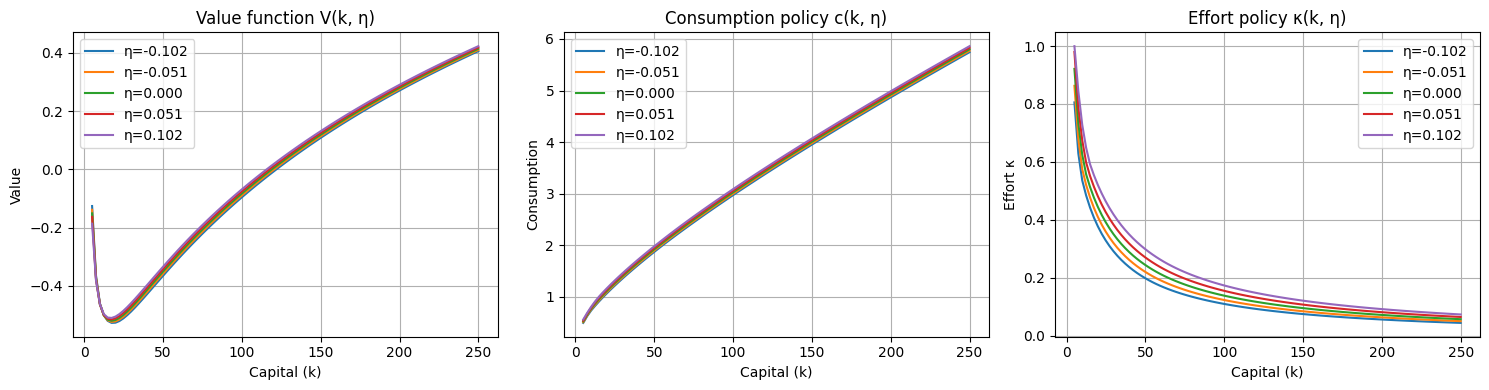

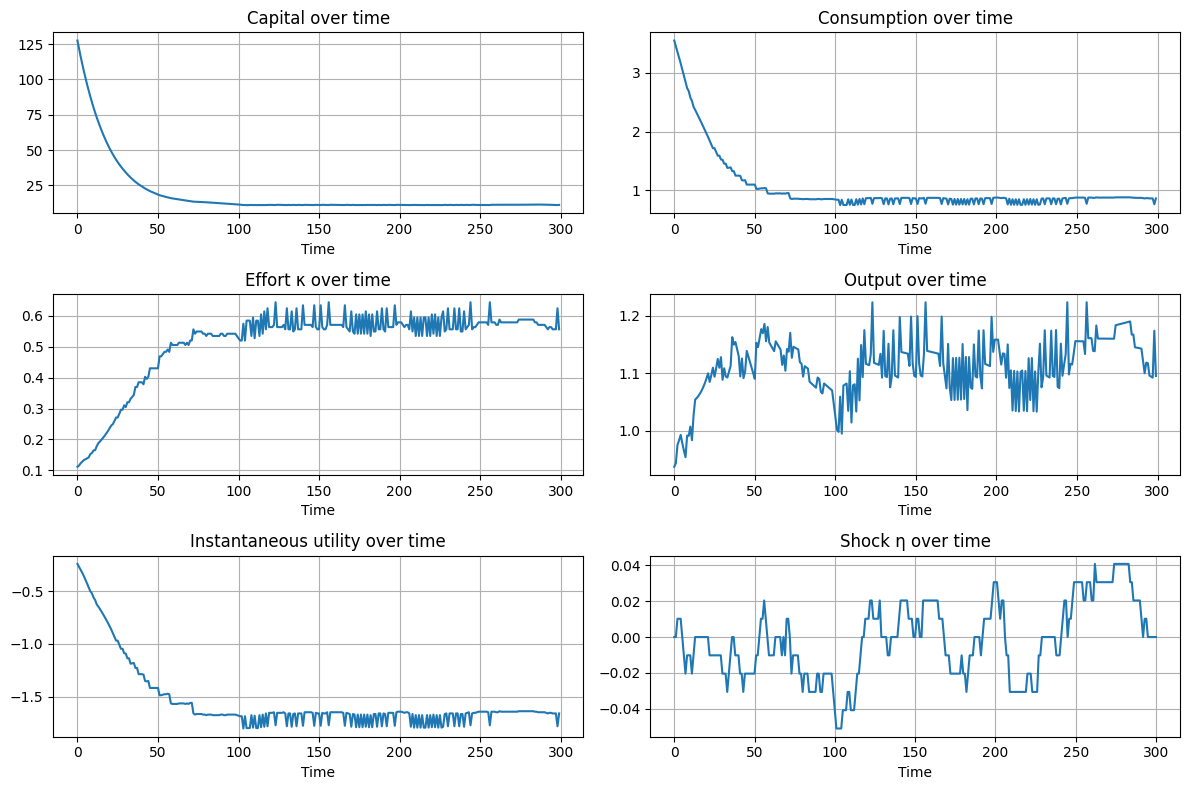

In [8]:
class HansenModel:

    def __init__(self):
        # Model parameters
        self.A = 2.0
        self.h0 = 0.53
        self.beta = 0.99
        self.alpha = 0.36
        self.delta = 0.025
        self.rho = 0.95
        self.sigma_eps = (0.712e-2)**2

        # bounds
        self.k_lower_bound = 5.0
        self.k_upper_bound = 250.0
        self.convergence_threshold = 1e-6
        self.max_iterations = 2000


        # Shock process
        self.number_of_shock_states = 21  # number of shock states
        self.number_of_capital_grid_points = 100  # number of capital grid points
        self.eta = np.zeros(self.number_of_shock_states)
        self.pi = np.zeros((self.number_of_shock_states, self.number_of_shock_states))

        # Grids and policy functions
        self.k = np.linspace(self.k_lower_bound, self.k_upper_bound, self.number_of_capital_grid_points)
        self.kappa = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))
        self.c = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))
        self.c_new = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))
        self.RHS = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))

        # Placeholder for spline coefficients (not needed if using CubicSpline directly)
        self.splines = [None] * self.number_of_shock_states  # list of Spline objects, one per shock



    def discretize_ar(self, mu=0.0, return_stationary=False):
        """
        Discretizes AR(1) process using quantecon's Rouwenhorst method.
        """
        mc = qe.markov.approximation.rouwenhorst(
            n=self.number_of_shock_states,
            rho=self.rho,
            sigma=self.sigma_eps**0.5,  # sigma_eps is variance; take sqrt for std.dev
            mu=mu
        )
        self.eta = mc.state_values + mu  # shift grid to have mean mu if desired
        self.pi = mc.P

        if return_stationary:
            # Compute stationary distribution: left eigenvector of eigenvalue 1
            eigvals, eigvecs = np.linalg.eig(self.pi.T)
            stat_idx = np.isclose(eigvals, 1)
            w = np.real(eigvecs[:, stat_idx]).flatten()
            w /= w.sum()
            self.stationary_dist = w  # optional: store as attribute
        else:
            self.stationary_dist = None
    
    def simulate_shocks(self, T=100, seed=42):
        np.random.seed(seed)
        n = self.pi.shape[0]
        shocks = np.zeros(T, dtype=int)
        shocks[0] = n // 2
        for t in range(1, T):
            shocks[t] = np.searchsorted(np.cumsum(self.pi[shocks[t-1]]), np.random.rand())
        return shocks


    def initialize_policy(self):
        """
        Initialize kappa and consumption policies.
        """
        for i in range(self.number_of_shock_states):
            self.kappa[:, i] = 0.9
            self.c[:, i] = np.exp(self.eta[i]) * self.k**self.alpha * (self.kappa[:, i] * self.h0)**(1 - self.alpha)
            self.c_new[:, i] = self.c[:, i]

    def interpolate(self):
        """
        Calculate RHS and fit splines for each shock state.
        """
        for i in range(self.number_of_shock_states):
            rhs_values = np.zeros(self.number_of_capital_grid_points)
            for j in range(self.number_of_capital_grid_points):
                acc = 0.0
                for k in range(self.number_of_shock_states):
                    term = 1 + self.alpha * np.exp(self.eta[k]) * \
                        (self.k[j] / (self.kappa[j, k] * self.h0))**(self.alpha - 1) - self.delta
                    acc += self.pi[i, k] * term / self.c_new[j, k]
                rhs_values[j] = self.beta * acc
            self.RHS[:, i] = rhs_values
            self.splines[i] = interp1d(
                self.k, rhs_values,
                kind='linear',
                fill_value='extrapolate',
                assume_sorted=True
)

    def foc(self, kappa_guess, current_capital, shock_state_id):
        """
        First-order condition residual.
        """
        kappa_act = np.clip(kappa_guess, 1e-10, 1 - 1e-10)

        c_act = -(1 - self.alpha) * np.exp(self.eta[shock_state_id]) * \
                (current_capital / (kappa_act * self.h0))**self.alpha * self.h0 / (self.A * np.log(1 - self.h0))

        kplus = (1 - self.delta) * current_capital + np.exp(self.eta[shock_state_id]) * current_capital**self.alpha * (kappa_act * self.h0)**(1 - self.alpha) - c_act

        if kplus <= self.k_upper_bound:
            rhs_val = self.splines[shock_state_id](kplus)
        else:
            # Linear extrapolation if kplus > k_upper_bound
            slope = (self.RHS[-1, shock_state_id] - self.RHS[-2, shock_state_id]) / (self.k[-1] - self.k[-2])
            rhs_val = slope * (kplus - self.k_upper_bound) + self.RHS[-1, shock_state_id]

        return 1.0 / c_act - rhs_val

    def solve(self, verbose=False):
        """
        Iterate until policy convergence.
        """
        self.discretize_ar() #replace with some value for non 0 mean
        self.initialize_policy()

        damping = 0.9  # weight on previous c (for smoothing)
        
        for iter in range(1, self.max_iterations + 1):
            # Step 1: update interpolants
            self.interpolate()

            for j in range(self.number_of_capital_grid_points):
                current_k = self.k[j]
                
                for s in range(self.number_of_shock_states):
                    x0 = self.kappa[j, s]
                    
                    # Step 2: check sign change in bracket
                    f_lower = self.foc(1e-8, current_k, s)
                    f_upper = self.foc(1.0, current_k, s)
                    
                    if np.isnan(f_lower) or np.isnan(f_upper):
                        if verbose:
                            print(f"[Warning] NaN in FOC at iter={iter}, k_idx={j}, shock_idx={s}")
                        continue

                    if f_lower * f_upper > 0:
                        if verbose:
                            print(f"[Info] No sign change in FOC at iter={iter}, k_idx={j}, shock_idx={s}. "
                                f"f(0)={f_lower:.4e}, f(1)={f_upper:.4e}")
                        # fallback: keep last κ
                        continue
                    for κ in [0.1, 0.5, 0.9, 0.99]:
                        val = self.foc(κ, current_k, s)
                        if verbose:
                            print(f"FOC at κ={κ:.2f}: {val:.4e}")
                    # Step 3: solve for optimal κ
                    try:
                        sol = root_scalar(
                            self.foc, args=(current_k, s),
                            method='bisect', bracket=[1e-8, 1.0], x0=x0
                        )
                        if sol.converged:
                            self.kappa[j, s] = sol.root
                        else:
                            if verbose:
                                print(f"[Warning] Root finding did not converge at iter={iter}, k_idx={j}, shock_idx={s}")
                            # fallback: keep last κ
                    except Exception as e:
                        if verbose:
                            print(f"[Error] Exception in root finding at iter={iter}, k_idx={j}, shock_idx={s}: {e}")
                        # fallback: keep last κ

                    # Step 4: update consumption policy based on new κ
                    try:
                        self.c_new[j, s] = -(1 - self.alpha) * np.exp(self.eta[s]) * \
                            (current_k / (self.kappa[j, s] * self.h0))**self.alpha * self.h0 / \
                            (self.A * np.log(1 - self.h0))
                    except Exception as e:
                        if verbose:
                            print(f"[Error] Failed to compute c_new at iter={iter}, k_idx={j}, shock_idx={s}: {e}")
                        self.c_new[j, s] = 1e-8  # fallback small positive

            # Step 5: check convergence
            con_lev = np.max(np.abs(self.c_new - self.c) / np.maximum(np.abs(self.c), 1e-10))
            if verbose:
                print(f"Iter {iter:4d} | Convergence level: {con_lev:.7e}")

            if con_lev < self.convergence_threshold:
                if verbose:
                    print("Converged!")
                return

            # Step 6: damping update
            self.c = damping * self.c + (1 - damping) * self.c_new

        print("[Warning] Maximum iterations reached without convergence.")
    
    
    
    def report(self, shock_indices=None):
        """
        Print or plot results (placeholder).
        """
        print("Final kappa policy shape:", self.kappa.shape)
        print("Final consumption policy shape:", self.c.shape)
        if shock_indices is None:
        # Pick 5 evenly spaced indices
            shock_indices = np.linspace(0, self.number_of_shock_states - 1, 5, dtype=int)

        const_term = self.A * np.log(1 - self.h0)

        #plot
        plt.figure(figsize=(15, 4))

        # value function
        plt.subplot(1, 3, 1)
        for i in shock_indices:
            utility = np.log(self.c[:, i]) + const_term
            continuation = self.RHS[:, i]  # already β × E[…]
            V = utility + continuation
            plt.plot(self.k, V, label=f"η={self.eta[i]:.3f}")
        plt.title("Value function V(k, η)")
        plt.xlabel("Capital (k)")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)

        # consumption policy
        plt.subplot(1, 3, 2)
        for i in shock_indices:
            plt.plot(self.k, self.c[:, i], label=f"η={self.eta[i]:.3f}")
        plt.title("Consumption policy c(k, η)")
        plt.xlabel("Capital (k)")
        plt.ylabel("Consumption")
        plt.legend()
        plt.grid(True)

        # kappa policy
        plt.subplot(1, 3, 3)
        for i in shock_indices:
            plt.plot(self.k, self.kappa[:, i], label=f"η={self.eta[i]:.3f}")
        plt.title("Effort policy κ(k, η)")
        plt.xlabel("Capital (k)")
        plt.ylabel("Effort κ")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def simulate_and_plot_time_series(self, T=300, seed=42):
        np.random.seed(seed)

        # Start from steady state or mid-point
        k_t = np.zeros(T+1)
        c_t = np.zeros(T)
        kappa_t = np.zeros(T)
        y_t = np.zeros(T)
        utility_t = np.zeros(T)
        shock_idx_t = np.zeros(T+1, dtype=int)
        eta_t = np.zeros(T+1)

        k_t[0] = np.mean(self.k)  # start at mean capital

        # Initial shock state: middle index
        shock_idx_t[0] = self.number_of_shock_states // 2
        eta_t[0] = self.eta[shock_idx_t[0]]

        for t in range(T):
            # Get policy at current k and shock:
            # Find nearest k grid point
            ik = np.argmin(np.abs(self.k - k_t[t]))
            is_ = shock_idx_t[t]

            c_t[t] = self.c[ik, is_]
            kappa_t[t] = self.kappa[ik, is_]
            eta_t[t] = self.eta[is_]

            # Compute output
            y_t[t] = np.exp(eta_t[t]) * k_t[t]**self.alpha * (kappa_t[t]*self.h0)**(1 - self.alpha)

            # Instantaneous utility
            utility_t[t] = np.log(c_t[t]) + self.A * np.log(1 - self.h0)

            # Next capital
            k_t[t+1] = (1 - self.delta)*k_t[t] + y_t[t] - c_t[t]

            # Draw next shock index
            shock_idx_t[t+1] = np.random.choice(
                self.number_of_shock_states, p=self.pi[is_]
            )

        # Plot
        fig, axs = plt.subplots(3, 2, figsize=(12, 8))

        axs[0,0].plot(k_t[:-1])
        axs[0,0].set_title("Capital over time")
        axs[0,0].set_xlabel("Time")
        axs[0,0].grid(True)

        axs[0,1].plot(c_t)
        axs[0,1].set_title("Consumption over time")
        axs[0,1].set_xlabel("Time")
        axs[0,1].grid(True)

        axs[1,0].plot(kappa_t)
        axs[1,0].set_title("Effort κ over time")
        axs[1,0].set_xlabel("Time")
        axs[1,0].grid(True)

        axs[1,1].plot(y_t)
        axs[1,1].set_title("Output over time")
        axs[1,1].set_xlabel("Time")
        axs[1,1].grid(True)

        axs[2,0].plot(utility_t)
        axs[2,0].set_title("Instantaneous utility over time")
        axs[2,0].set_xlabel("Time")
        axs[2,0].grid(True)

        axs[2,1].plot(eta_t)
        axs[2,1].set_title("Shock η over time")
        axs[2,1].set_xlabel("Time")
        axs[2,1].grid(True)

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    model = HansenModel()
    model.solve()
    model.report()
    model.simulate_and_plot_time_series()


## 9.11

Consider the following tax scheme:
$
g_t = \tau^w_t w_t l_t.
$

Lump sum taxation is excluded

## Household utility

Households maximize expected lifetime utility:
$
\max_{\{c_t, l_t, k_{t+1}\}} E_0 \sum_{t=0}^\infty \beta^t u(c_t, l_t)
$

subject to:
$
c_t + k_{t+1} = (1-\delta) k_t + (1-\tau^w_t) w_t l_t + r_t k_t.
$


## Lagrangian and optimality conditions

$
\mathcal{L} = E_0 \sum_{t=0}^\infty \beta^t \big[
u(c_t, l_t) + \lambda_t \big((1-\delta) k_t + (1-\tau^w_t) w_t l_t + r_t k_t - c_t - k_{t+1}\big)
\big].
$




### $\frac{\partial{\mathcal{L}}}{{\partial{(c_t)}}}$:
$
u_c(c_t, l_t) - \lambda_t = 0 
\quad \Rightarrow \quad \lambda_t = u_c(c_t, l_t).
$


### $\frac{\partial{\mathcal{L}}}{\partial{(l_t)}}$:
$
u_l(c_t, l_t) + \lambda_t (1-\tau^w_t) w_t = 0
$
$
\Rightarrow u_l(c_t, l_t) = - u_c(c_t, l_t) (1-\tau^w_t) w_t.
$


### $\frac{\partial{\mathcal{L}}}{\partial{(k_{t+1})}}$:
$
-\lambda_t + \beta E_t[\lambda_{t+1} (r_{t+1} + 1 - \delta)] = 0
$
$
\Rightarrow 1 = \beta E_t \left[\frac{u_c(c_{t+1}, l_{t+1})}{u_c(c_t, l_t)} (r_{t+1} + 1 - \delta) \right].
$


## Euler equation:
$
1 = \beta E_t \left[\frac{u_c(c_{t+1}, l_{t+1})}{u_c(c_t, l_t)} (r_{t+1} + 1 - \delta) \right].
$

## Intratemporal (labour supply) condition:
$
u_l(c_t, l_t) = - u_c(c_t, l_t) (1-\tau^w_t) w_t.
$

## B Implementation

* Modification of household budget constraint:
$
c_t + k_{t+1} = (1-\delta) k_t + (1-\tau^w_t) w_t l_t + r_t k_t.
$

* Government tax revenue:
$
g_t = \tau^w_t w_t l_t.
$

---

### Computational steps:
- Discretize productivity shocks 
- Use a capital grid and shock grid to iterate and state \((k_t, \eta_t)\):
- Compute \( w_t, r_t \) from the production function.
- Compute the tax rate:
$
\tau^w_t = \frac{g_t}{w_t l_t}.
$
- Update the function with $((1-\tau^w_t)w_tl_t)$ instead of $(w_t l_t)$.

---

## C Policy comparison
Compare 
1. Constant government spending: $(g_t = \bar{g})$
2. Procyclical government consumption: $(g_t)$ increasing function in $(\eta_t)$


### Effect on endogenous \tau:
- constant spending:  
  When $(w_t l_t)$ rises $(\tau^w_t = g_t / (w_t l_t))$ falls, leading to a countercyclical tax rate.

- **Procyclical $(g_t)$**:  
  $(g_t)$ rises with $(w_t l_t)$, keeping $(\tau^w_t)$ stable or increasing.

---

### Comparison to lump-sum:
- With lump-sum taxes, optimality condiotions become:
$
u_l(c_t, l_t) = - u_c(c_t, l_t) w_t.
$
This does not affect labor incentives, only income.


$
u_l(c_t, l_t) / u_c(c_t, l_t) = - (1-\tau^w_t) w_t.
$
Affects labour incentives and welfare.

---

## Welfare cost
- Simulate the model for both cases
- Plot:
    * $(\tau^w_t)$ in $t$
    * Labour supply $(l_t)$
    * Output $(y_t)$, consumption $(c_t)$
- Expected welfare:
$
E_0 \sum_{t=0}^\infty \beta^t u(c_t, l_t).
$
- Compare policies.

---

## summery:
* Distortionary taxes endogenises variation in tax rates.
* Procyclical government spending keeps $\tau$ stable, but increase volatility.
* Constant government spending implies countercyclical $\tau$. This has a consumption smoothing effect, but crowds out labor during recession.


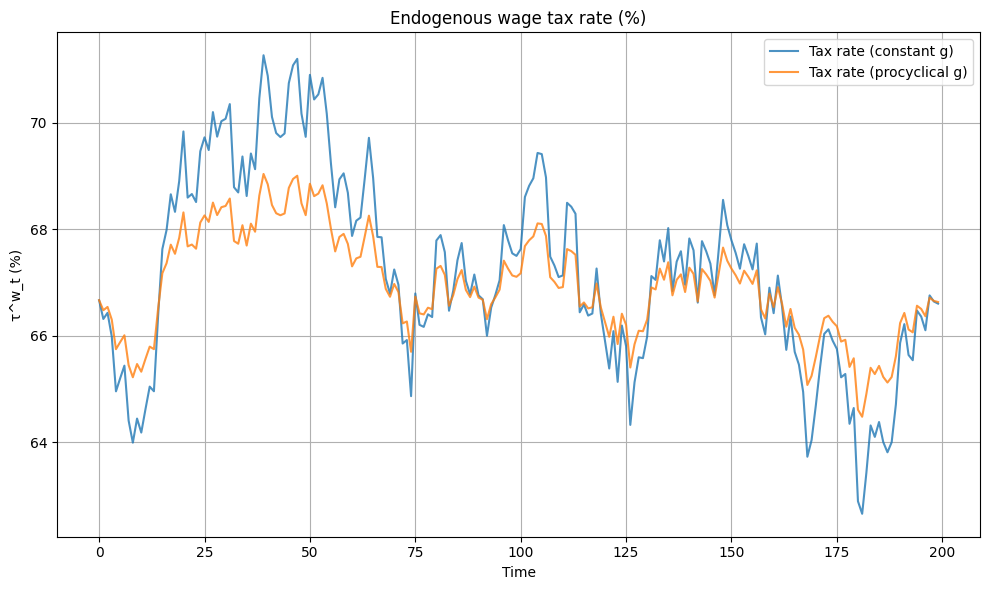

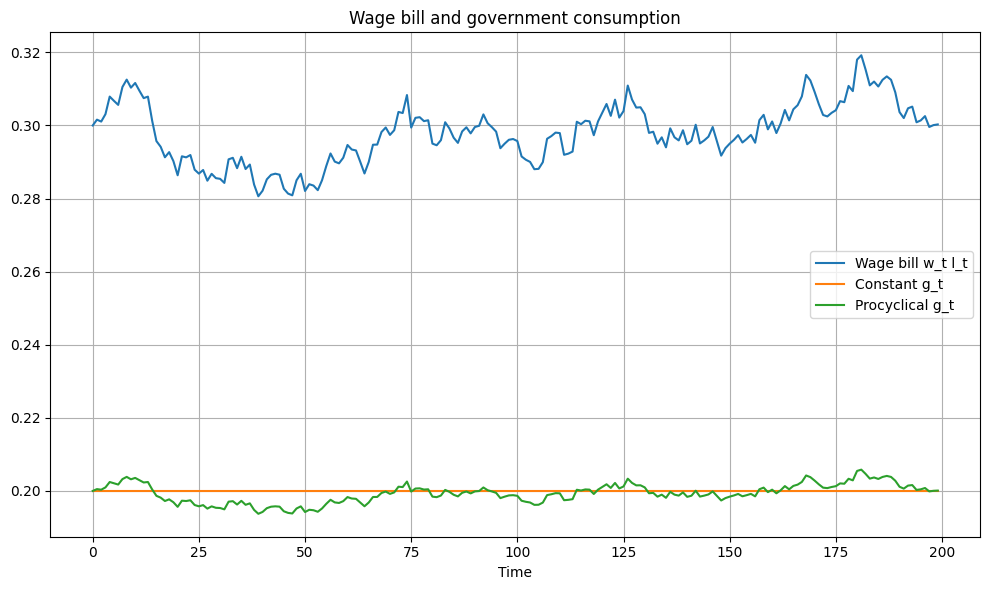

In [5]:

np.random.seed(42)

periods = 200  # periods
persistence = 0.95
shock_std = 0.01

#Simulate productivity shocks
eta = np.zeros(periods)
for t in range(1, periods):
    eta[t] = persistence * eta[t-1] + shock_std * np.random.randn()

# Assume baseline wage and labour supply (simplified)
w_base = np.exp(eta)  # wage as a simple function in eta (productivity)
l_base = 0.3 + 0.02 * eta  # Productivity as a simple function in eta (increasing)

# Scenario 1: constant spend
g_const = np.full(periods, 0.2)  # some constant level
tau_const = g_const / (w_base * l_base)

# Scenario 2: procyclical spend
g_procyclical = 0.2 * (1 + 0.5 * eta)  # spend increases in booms
tau_procyclical = g_procyclical / (w_base * l_base)

# Plot
plt.figure(figsize=(10,6))
plt.plot(tau_const * 100, label="Tax rate (constant)", alpha=0.8)
plt.plot(tau_procyclical * 100, label="Tax rate (procyclical)", alpha=0.8)
plt.title("Endogenous wage tax rate (%)")
plt.xlabel("Time")
plt.ylabel("τ^w_t (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: plot consumption or labour supply variations
plt.figure(figsize=(10,6))
plt.plot(w_base * l_base, label="Wage bill w_t l_t")
plt.plot(g_const, label="Constant g_t")
plt.plot(g_procyclical, label="Procyclical g_t")
plt.title("Wage bill and government consumption")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


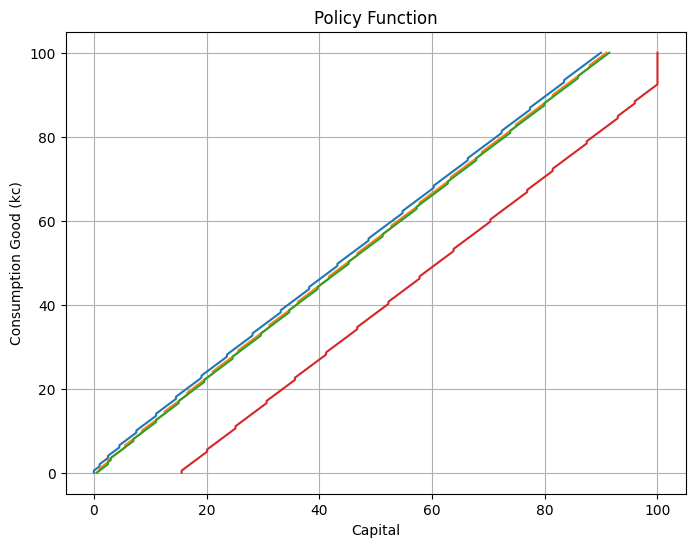

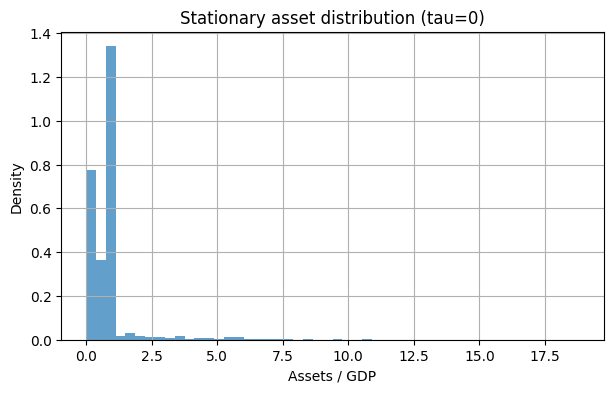

tau=0: mean=0.852, median=0.855, std=1.031


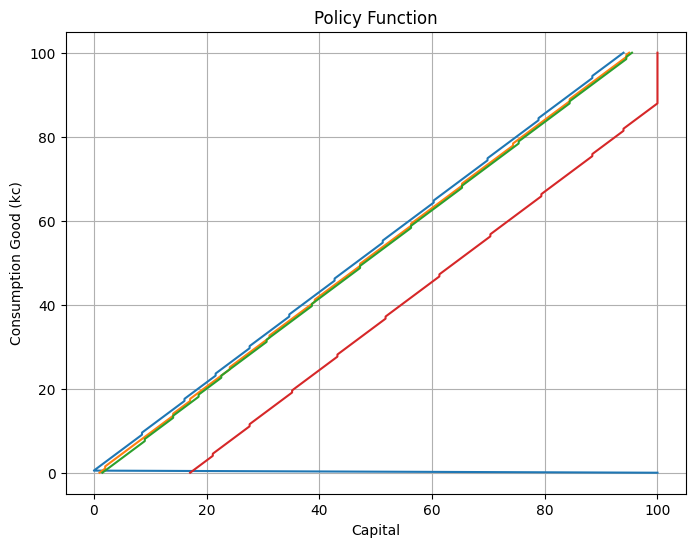

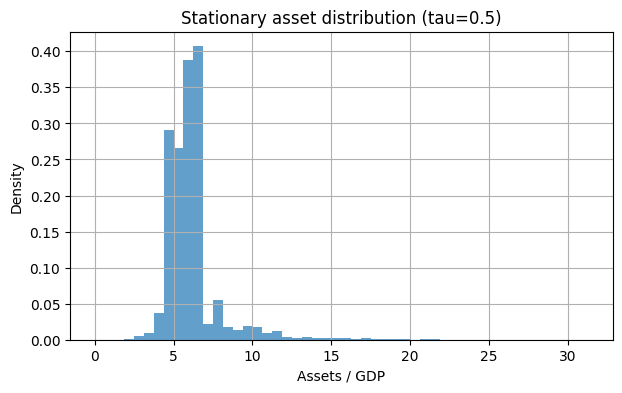

tau=0.5: mean=6.086, median=5.811, std=1.766


In [ ]:
# Model parameters
alpha, delta, beta, sigma = 0.36, 0.10, 0.96, 2
y_vals = np.array([0.1, 0.8, 1.2, 10])
pi_y = np.array([
    [0.50, 0.50, 0.00, 0.00],
    [0.05, 0.90, 0.05, 0.00],
    [0.02, 0.04, 0.93, 0.01],
    [0.00, 0.00, 0.80, 0.20]
])

a_min, a_max, a_size = 0, 100, 200
a_grid = np.linspace(a_min, a_max, a_size)

# Function to compute equilibrium prices
def get_prices(K, L=1):
    Y = K**alpha * L**(1-alpha)
    r = alpha * (K/L)**(alpha-1) - delta
    w = (1 - alpha) * (K/L)**alpha
    return r, w

# Household problem
def solve_household(tau, r, w):
    V = np.zeros((a_size, len(y_vals)))
    policy_a = np.zeros_like(V)

    for it in range(iterations):
        V_new = np.zeros_like(V)
        for iy, y in enumerate(y_vals):
            income = w * y + tau * r * K_guess
            for ia, a in enumerate(a_grid):
                cons_next = []
                for ia_next, a_next in enumerate(a_grid):
                    c = income + (1+(1 - tau)*r)*a - a_next
                    c = max(c, 1e-8)
                    u = c**(1 - sigma) / (1 - sigma)
                    EV = np.dot(pi_y[iy], V[ia_next])
                    cons_next.append(u + beta * EV)
                V_new[ia, iy] = np.max(cons_next)
                policy_a[ia, iy] = a_grid[np.argmax(cons_next)]
        diff = np.max(np.abs(V_new - V))
        if diff < convergence_threshold:
            break
        V = V_new
    return policy_a

# Simulate stationary distribution
def simulate_distribution(policy_a, T=100000):
    assets = np.zeros(T)
    y_idx = np.zeros(T, dtype=int)
    y_idx[0] = np.random.choice(len(y_vals))

    for t in range(1, T):
        ia = np.searchsorted(a_grid, assets[t-1])
        a_next = policy_a[ia, y_idx[t-1]]
        assets[t] = a_next
        y_idx[t] = np.random.choice(len(y_vals), p=pi_y[y_idx[t-1]])
    return assets

# Solve and plot for τ=0 and τ=0.5
results = {}
for tau in [0, 0.5]:
    K_guess = 20  # initial guess
    r, w = get_prices(K_guess)
    policy_a = solve_household(tau, r, w)
    assets = simulate_distribution(policy_a)
    GDP = K_guess**alpha  # since L=1
    mean_a, median_a, std_a = np.mean(assets)/GDP, np.median(assets)/GDP, np.std(assets)/GDP
    results[tau] = {'assets': assets, 'mean': mean_a, 'median': median_a, 'std': std_a}

    plt.figure(figsize=(7,4))
    plt.hist(assets/GDP, bins=50, density=True, alpha=0.7)
    plt.title(f"Stationary asset distribution (tau={tau})")
    plt.xlabel("Assets / GDP")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

    print(f"tau={tau}: mean={mean_a:.3f}, median={median_a:.3f}, std={std_a:.3f}")


## Interpertation

When $\tau=0$ the median and mean of the distribution are farily close together (0.855 and 0.852 respectively). The distribution is extremely left skewed with a variation coefficient $\frac{mean}{std}$ of ~1.2. indicating most households are poor, and stay poor, while rich households accumelate a lot of assets.
Raising $\tau$ to 0.5 decreases return on invested capital, and redistributes assets to poorer household via lump sum transfers, which reduces the skewness of the curve as well as increases mean and average assets. For $\tau=0.5$ we observe a variation coefficient of ~0.2, indicating assets are much more closely distributed to the mean, which indicates the capital gain tax increased equality in terms of asset distribution


Running simulation for τ=0


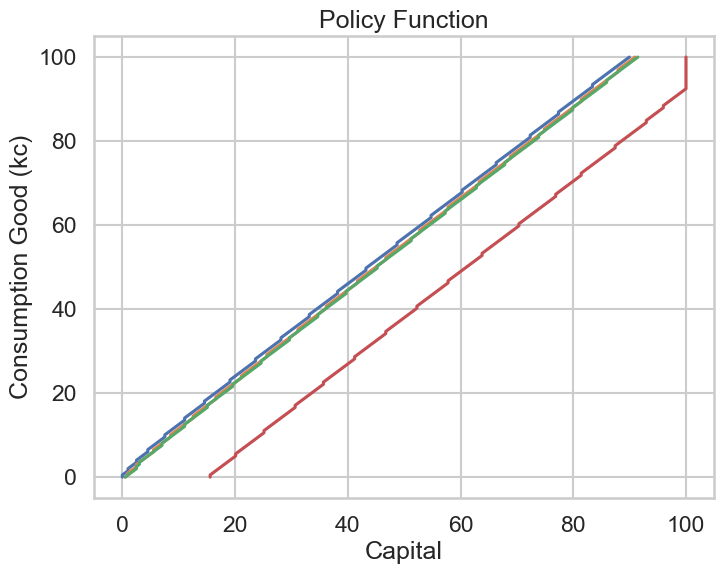

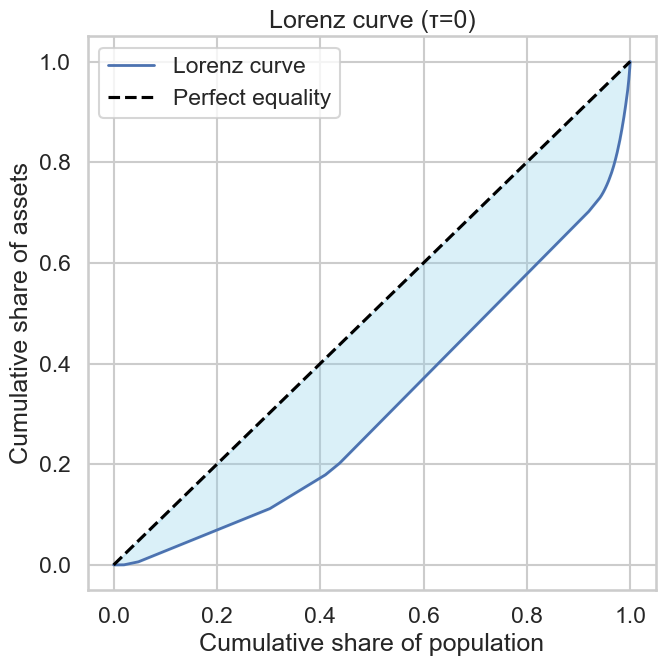

Gini coefficient: 0.365

Running simulation for τ=0.5


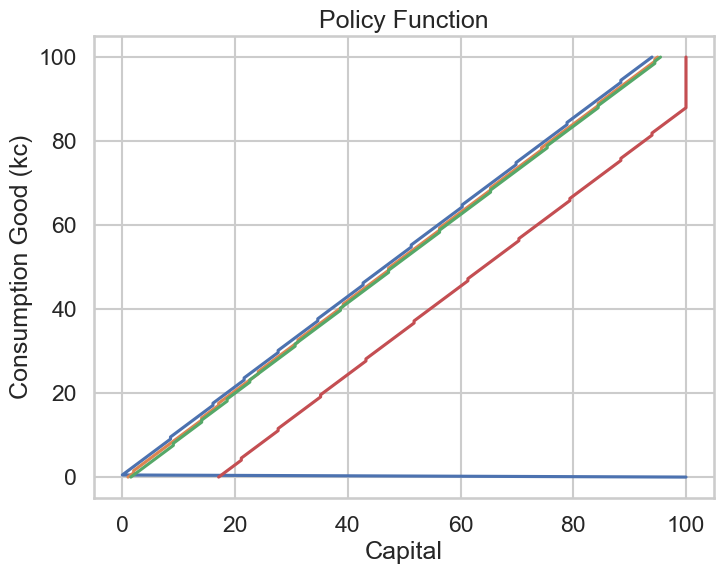

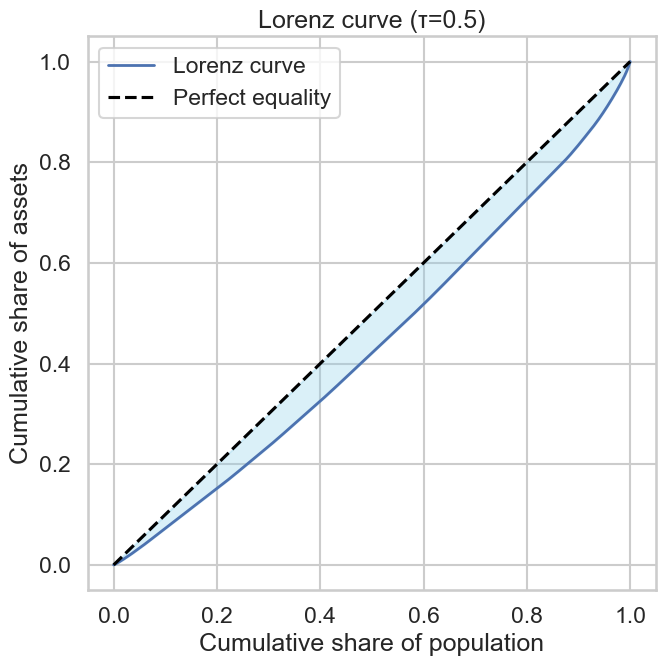

Gini coefficient: 0.122
τ=0: mean=2.424, std=2.870, coeff. of variation=1.184, Gini=0.365
τ=0.5: mean=17.774, std=5.021, coeff. of variation=0.282, Gini=0.122


In [36]:
import seaborn as sns
sns.set(style='whitegrid', context='talk')  # clean style
def plot_lorenz_and_gini(assets, title='Lorenz curve'):
    sorted_assets = np.sort(assets)
    cum_assets = np.cumsum(sorted_assets)
    total_assets = cum_assets[-1]
    
    cum_assets_pct = np.insert(cum_assets / total_assets, 0, 0)
    population_pct = np.insert(np.arange(1, len(assets)+1) / len(assets), 0, 0)
    
    plt.figure(figsize=(7, 7))
    sns.lineplot(x=population_pct, y=cum_assets_pct, lw=2, label='Lorenz curve')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Perfect equality')
    plt.fill_between(population_pct, cum_assets_pct, population_pct, color='skyblue', alpha=0.3)
    
    plt.xlabel('Cumulative share of population')
    plt.ylabel('Cumulative share of assets')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    B = np.trapezoid(cum_assets_pct, population_pct)
    gini = (0.5 - B) / 0.5
    print(f"Gini coefficient: {gini:.3f}")
    return gini


assets_by_tau = {}
gini_by_tau = {}

for tau in [0, 0.5]:
    print(f"\nRunning simulation for τ={tau}")
    K_guess = 20
    r, w = get_prices(K_guess)
    policy_a = solve_household(tau, r, w)
    assets = simulate_distribution(policy_a)
    assets_by_tau[tau] = assets
    
    gini = plot_lorenz_and_gini(assets, title=f'Lorenz curve (τ={tau})')
    gini_by_tau[tau] = gini

for tau in assets_by_tau:
    mean = np.mean(assets_by_tau[tau])
    std = np.std(assets_by_tau[tau])
    coef_var = std / mean
    print(f"τ={tau}: mean={mean:.3f}, std={std:.3f}, coeff. of variation={coef_var:.3f}, Gini={gini_by_tau[tau]:.3f}")
